In [1]:
import warnings
warnings.filterwarnings('ignore')

In [63]:
import pandas as pd
import numpy as np
import struct

from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array, as_float_array

from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from lightgbm import LGBMClassifier 

from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
from sklearn.model_selection import KFold, train_test_split, cross_val_score

from hyperopt import fmin, tpe, hp
from bayes_opt import BayesianOptimization

from scipy.stats import entropy
from scipy import sparse

import matplotlib.pyplot as plt

from copy import deepcopy as copy

%matplotlib inline

# Класс дискретизации

In [3]:
class MaxentropyMedianDichtomizationTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, n_splits, verbose=False):
        self.n_splits = n_splits
        
        self.n_samples = None
        self.n_features = None
        self._splits = None
        self._splits_indices = None
    
    def _check_X(self, X, n_features=None):
        _X = None
        if not hasattr(X, 'dtype'):
            _X = check_array(as_float_array(X))
        _X = check_array(X)
        
        if self.n_features:
            if _X.shape[1] != self.n_features:
                raise Exception('X has {} columns while {} are expected'.format(_X.shape[1], self.n_features))
        return _X
    
    def _calc_entropy(self, X, split_bias):
        a = np.sum(X < split_bias)
        b = np.sum(X >= split_bias)

        p = np.array([a / X.shape[0], b / X.shape[0]])
        return -np.sum(np.log(p + 1) * p)


    def _get_maxentropy_split(self, X):
        # O(n^2)
        block_size = X.shape[0]
        ix_max_entropy = -1
        X_diff = np.diff(X)

        start_point = X.shape[0] // 2
        
        right_point = right_entropy = None
        left_point = left_entropy =None
        
        max_entropy = -1
        max_probas = None
        # define point where to start looking for
        # highest entropy
        if X_diff[start_point] == 0:
            _right_indices = np.where(X_diff[start_point:] > 0)[0]
            _left_indices = np.where(X_diff[:start_point] > 0)[0]
            
            if _right_indices.any():
                right_point = _right_indices[0] + start_point
            
            if _left_indices.any():
                left_point = _left_indices[-1]
            
            # if we have constant series
            if _right_indices is None and _left_indices is None:
                return 0, -1
            
            if right_point:
                right_entropy = self._calc_entropy(X, X[right_point])
        
            if left_point:
                left_entropy = self._calc_entropy(X, X[left_point])
        else:
            right_point = start_point + 1
            left_point = start_point - 1
            
            right_entropy = self._calc_entropy(X, X[right_point])
            left_entropy = self._calc_entropy(X, X[left_point])
            center_entropy = self._calc_entropy(X, X[start_point])
            
            if center_entropy > left_entropy and center_entropy > right_entropy:
                return center_entropy, start_point

        # if entropy at the point left to the starting point is higher
        # search for entropy maxima
        if right_point and  (not left_point or right_entropy > left_entropy):
            for j in range(right_point + 1, block_size):
                local_entropy = self._calc_entropy(X, X[j])
                if local_entropy > right_entropy:
                    right_point = j
                    right_entropy = local_entropy
                else:
                    return right_entropy, right_point
        elif left_point:
            for j in reversed(range(0, left_point - 1)):
                local_entropy = self._calc_entropy(X, X[j])
                if local_entropy > left_entropy:
                    left_point = j
                    left_entropy = local_entropy
                else:
                    return left_entropy, left_point
        
        return 0, -1

    def _dichtomize(self, X):
        # O(n^2 * log n)
        
        _iters = np.log2(self.n_splits)
        if _iters - int(_iters) != 0:
            raise Exception('number of bins should be of a power of 2')
        
        # make first maxentropy split
        _, initial_bin = self._get_maxentropy_split(X)
        splits_current_feature = [(0, initial_bin), (initial_bin, self.n_samples - 1)]
        for i in range(int(_iters) - 1):
            # an empty list for splits in current iteration
            _splits = list()
            for j in splits_current_feature:
                entropy, index = self._get_maxentropy_split(X[j[0]: j[1]])
                if entropy == 0:
                    _splits += [(j[0], j[1])]
                else:
                    _splits += [(j[0], j[0] + index), (j[0] + index, j[1])]

            splits_current_feature = _splits
            
        return splits_current_feature
    
    def _convert(self, X, ix):
        result = list()
        for x in X.flatten():
            result.append(np.argwhere([k[0] <= x and x < k[1] for k in self._splits[ix]]))
        return np.array(result).reshape(-1, 1) 
    
    def fit(self, X):
        X = self._check_X(X)
        self.n_samples, self.n_features = X.shape
        
        self._splits = list()
        self._splits_indices = list()
        
        for ix in range(self.n_features):
            x = np.sort(X[:, ix].flatten())
            _indices = self._dichtomize(x.flatten())
            
            self._splits_indices.append(_indices)
            self._splits.append([[x[i[0]], x[i[1]]] for i in _indices])
            
            self._splits[-1][0][0] = -np.inf
            self._splits[-1][-1][1] = np.inf
            
            self._splits = np.array(self._splits)
            
        return self
    
    def transform(self, X):
        _, n_features = X.shape
        X = self._check_X(X, n_features)
        
        X_categorical = list()
        for ix in range(n_features):
            X_categorical.append(self._convert(X, ix))
            
        return np.hstack(X_categorical)

In [78]:
class SomeFabulousTransformation(BaseEstimator):
    def __init__(self, base_estimator, dichtomized=False, n_splits=32, exhausitve=True, random_seed=42, verbose=1):
        self.base_estimator = base_estimator
        self.n_splits = n_splits
        self.random_seed = random_seed
        self.exhausitve = exhausitve
        self.verbose = verbose
        self.dichtomized=dichtomized
        self._feature_space = None
        self._feature_dichtomizers = None
        
    @staticmethod
    def _cross_entropy(p, q):
        p = np.array(p)
        q = np.array(q)
        q[q == 0] = 1e-9
        return -np.sum(p * np.log(q))
    
    @staticmethod
    def _synchronize_two_dicts(_from:dict, _to:dict):
        for i in np.setdiff1d(list(_from.keys()), list(_to.keys())):
            if i not in _to.keys():
                _to[i] = 0
            
            if i not in _from.keys():
                _from[i] = 0
            
    def _dichtomize(self, X):
        self._feature_dichtomizers = list()
        self._feature_space = list()
        
        if not self.dichtomized:
            for i in range(X.shape[1]):
                feature = X[:, i].reshape(-1, 1)
                dichtomizer = MaxentropyMedianDichtomizationTransformer(32).fit(feature)
                feature_dichtomized = dichtomizer.transform(feature)
                onehot_encoder = OneHotEncoder(sparse=True).fit(feature_dichtomized)

                self._feature_dichtomizers.append({'dichtomizer': dichtomizer, 'encoder': onehot_encoder})
                self._feature_space.append({'categorical': feature_dichtomized, 'binary': onehot_encoder.transform(feature_dichtomized)})
        else:
            for i in range(X.shape[1]):
                feature = X[:, i].reshape(-1, 1)
                onehot_encoder = OneHotEncoder(sparse=True).fit(feature)
                self._feature_dichtomizers.append({'dichtomizer': None, 'encoder': onehot_encoder})
                self._feature_space.append({'categorical': feature, 'binary': onehot_encoder.transform(feature)})
                
    
    def _calc_cross_entropy(self, ix_feature, pred, dataset_size):
        real = np.asarray(self._feature_space[ix_feature]['binary'].sum(1))
        pred = np.asarray(pred.sum(1))
        
        pred[np.argwhere(pred == 2)] = 1
        
        pred_category, pred_counts = np.unique(pred, return_counts=True)
        real_category, real_counts = np.unique(real, return_counts=True)

        pred_proba = pred_counts / dataset_size
        real_proba = real_counts / dataset_size

        real_stats = dict(zip(real_category, real_proba))
        pred_stats =  dict(zip(pred_category, pred_proba))

        SomeFabulousTransformation._synchronize_two_dicts(real_stats, pred_stats)
        
        return SomeFabulousTransformation._cross_entropy(list(real_stats.values()), list(pred_stats.values()))
    
    def _fit_transform(self, X, initial_feature_ix):
        dataset_size = X.shape[0]
        free_features_ix = [i for i in range(len(self._feature_space)) if i != initial_feature_ix]
        active_features_subset = [self._feature_space[initial_feature_ix]['binary']]
        active_features_subset_ix = [initial_feature_ix]
        
        while len(active_features_subset) != len(self._feature_space):
            max_entropy = -1
            max_entropy_feature_ix = -1
            max_entropy_feature_value = None
            
            if self.verbose > 1:
                print('currently processed {} features out of {}'.format(len(active_features_subset), len(self._feature_space)))
                print('number of active features {}'.format(len(active_features_subset)))
            
            for ix_current_feature in free_features_ix:
                if len(active_features_subset) > 1:
                    model_input_features = sparse.hstack(active_features_subset)
                else:
                    model_input_features = active_features_subset[0]
                
                estimator = copy(self.base_estimator)
                estimator.fit(model_input_features, self._feature_space[ix_current_feature]['categorical'].squeeze())
                
                pred = estimator.predict(model_input_features)

                pred_onehot = self._feature_dichtomizers[ix_current_feature]['encoder'].transform(pred.reshape(-1, 1))
                pred_diff = (pred_onehot != self._feature_space[ix_current_feature]['binary']).astype(np.int32)
                
                entropy = self._calc_cross_entropy(ix_current_feature, pred_diff, dataset_size)
                
                if entropy > max_entropy:
                    max_entropy_feature_value = pred_diff
                    max_entropy_feature_ix = ix_current_feature
                    max_entropy = entropy
                    
            free_features_ix.remove(max_entropy_feature_ix)
            active_features_subset.append(max_entropy_feature_value)
            active_features_subset_ix.append(max_entropy_feature_ix)
            
        return np.hstack(active_features_subset), active_features_subset_ix      
    
    def fit_transform(self, X):
        np.random.seed(self.random_seed)
        
        self._dichtomize(X)
        
        if not self.exhausitve:
            initial_feature_ix = np.random.randint(0, len(self._feature_space))
            return self._fit_transform(X, initial_feature_ix)
        
        features_subset = list()
        features_subset_ix = list()
        for initial_feature_ix in range(len(self._feature_space)):
            if self.verbose == 1:
                print('processing starting feature {}'.format(initial_feature_ix))
            _features_subset, _features_subset_ix = self._fit_transform(X, initial_feature_ix)
            
            features_subset.append(_features_subset)
            features_subset_ix.append(_features_subset_ix)
            
        return features_subset, np.vstack(features_subset_ix)

# RF regressor optimization code

In [5]:
def bayesian_optimization_lightgbm(X, y, cv=6, max_iter_opt=15):
    svr_opt = BayesianOptimization(
        lambda feature_fraction, bagging_freq, bagging_fraction, n_estimators: cross_val_score(
            LGBMClassifier(
                boosting_type='rf', 
                feature_fraction=feature_fraction, 
                bagging_freq=int(bagging_freq), 
                bagging_fraction=bagging_fraction,
                n_estimators=int(n_estimators)
            ),
            X, y.squeeze(), cv=KFold(n_splits=cv).split(X), scoring='accuracy'
        ).mean(),
        {'feature_fraction': (0.05, 0.95),
         'bagging_fraction': (0.05, 0.95),
         'bagging_freq': (1, 50),
         'n_estimators': (5, 50) },
        verbose=0
    )
    
    svr_opt.init(10)
    svr_opt.maximize(n_iter=max_iter_opt)
    
    return svr_opt.res['max']['max_params']#['C']

# Breast Cancer

In [7]:
df = pd.read_csv('./datasets/cancer/breast_cancer.csv')
y = df.diagnosis.replace('M', 0).replace('B', 1).values
X = np.asarray(df.drop(['diagnosis', 'id', 'Unnamed: 32'], axis=1).as_matrix())

In [8]:
params_opt = bayesian_optimization_lightgbm(X, y, cv=4, max_iter_opt=10)

In [9]:
params_opt['bagging_freq'] = int(params_opt['bagging_freq'])
params_opt['n_estimators'] = int(params_opt['n_estimators'])

In [11]:
models = {
    'rf': LGBMClassifier(boosting_type='rf', **params_opt),
    'lr': LogisticRegression(random_state=42, multi_class='ovr', solver='liblinear', C=10000, tol=1e-2),
    'svc': LinearSVC(multi_class='ovr', C=10000, tol=1e-2),
}

In [79]:
transform = SomeFabulousTransformation(models['lr'], exhausitve=True, verbose=1)

In [80]:
features, indices = transform.fit_transform(X)

processing starting feature 0
processing starting feature 1
processing starting feature 2
processing starting feature 3
processing starting feature 4
processing starting feature 5
processing starting feature 6
processing starting feature 7
processing starting feature 8
processing starting feature 9
processing starting feature 10
processing starting feature 11
processing starting feature 12
processing starting feature 13
processing starting feature 14
processing starting feature 15
processing starting feature 16
processing starting feature 17
processing starting feature 18
processing starting feature 19
processing starting feature 20
processing starting feature 21
processing starting feature 22
processing starting feature 23
processing starting feature 24
processing starting feature 25
processing starting feature 26
processing starting feature 27
processing starting feature 28
processing starting feature 29


In [84]:
unique_ix = np.unique(indices).tolist()
ix_counts = {i: 0 for i in unique_ix}

for row in indices:
    ranks = dict(zip(row.tolist(), reversed(range(row.shape[0]))))
    for i, j in ranks.items():
        ix_counts[i] += j / (row.shape[0]**2)

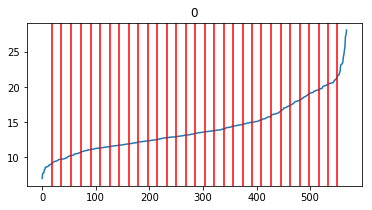

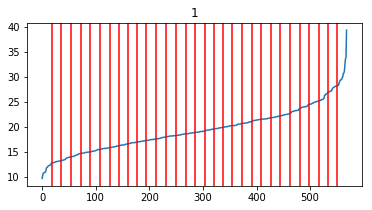

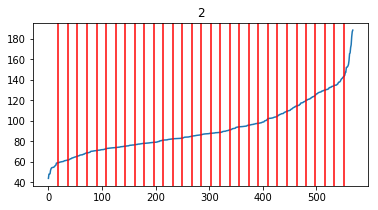

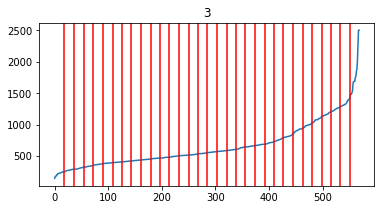

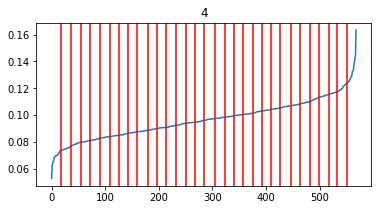

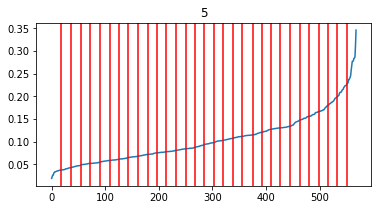

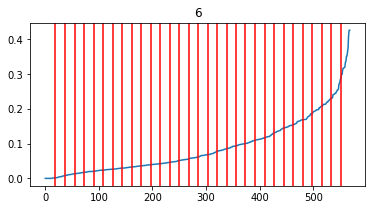

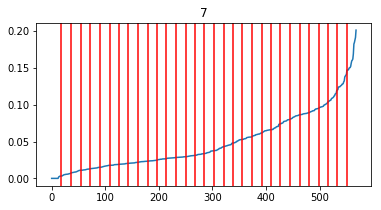

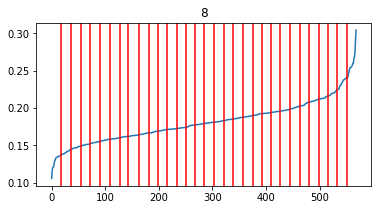

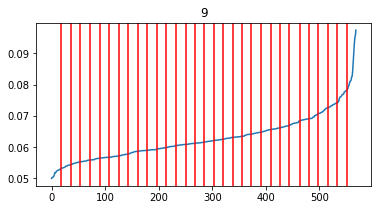

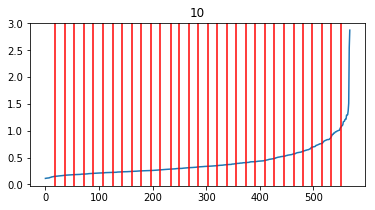

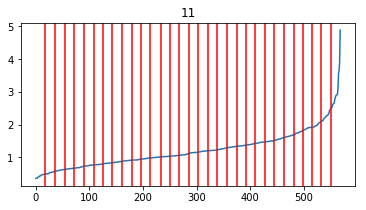

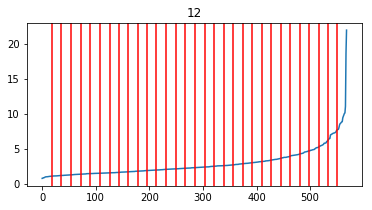

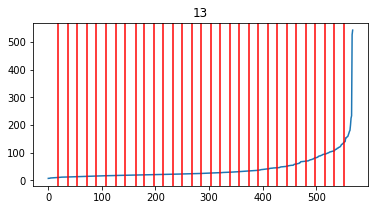

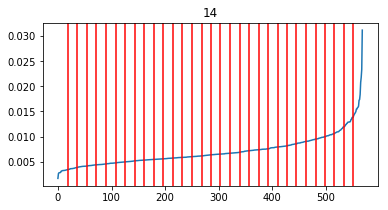

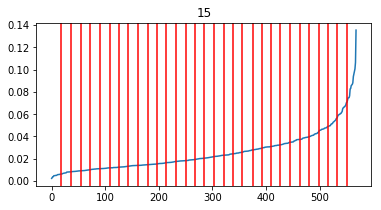

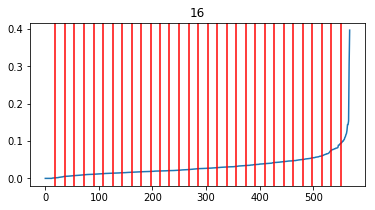

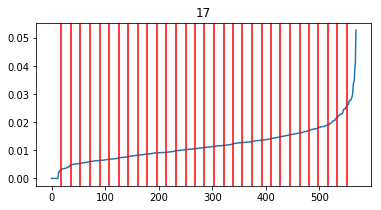

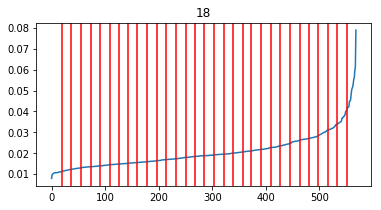

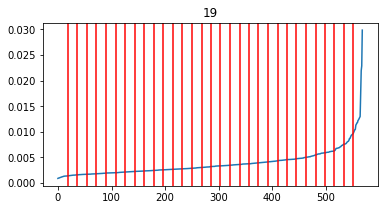

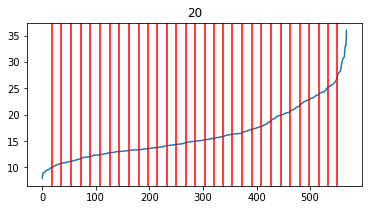

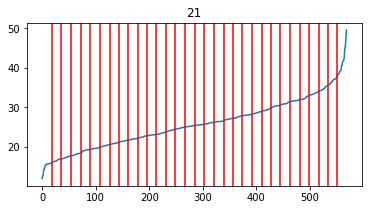

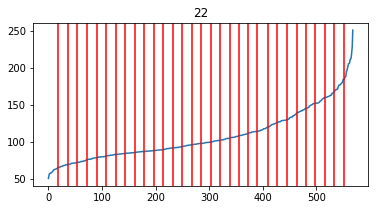

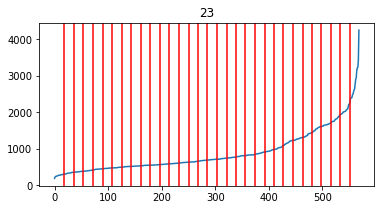

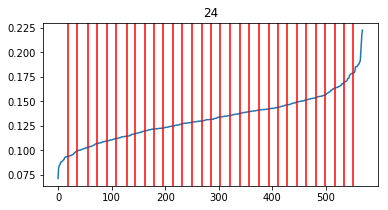

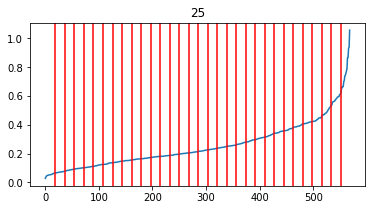

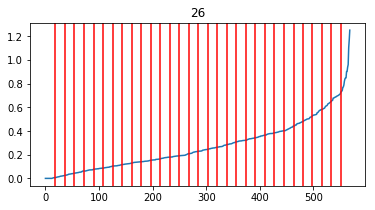

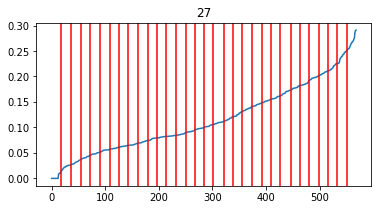

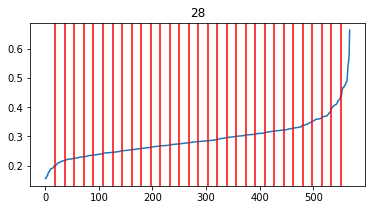

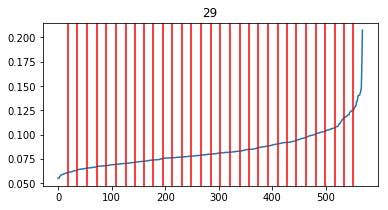

In [87]:
#pd.Series(np.sort(transform._feature_space[2]['categorical'].squeeze())).value_counts()
for i in range(X.shape[1]):
    pd.Series(np.sort(X[:, i].squeeze())).plot(figsize=(6, 3))
    for j in transform._feature_dichtomizers[i]['dichtomizer']._splits_indices[0][:-1]:
        plt.axvline(x=j[1], color='r')
    plt.title(i)
    plt.show()

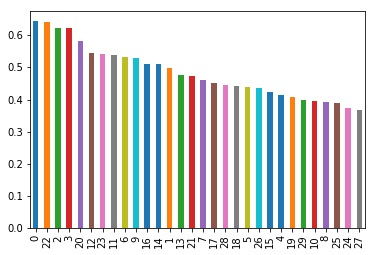

In [90]:
pd.Series(ix_counts).sort_values(ascending=False).plot(kind='bar')

In [96]:
top_10 = pd.Series(ix_counts).sort_values(ascending=False).index.values[:10]

In [97]:
X_train, X_val, y_train, y_val = train_test_split(X[:, top_10], y, test_size=0.1)
X_train, y_train = shuffle(X_train, y_train)

In [98]:
stats = {}

for k, model in models.items():
    stats[k] = []
    kfold = KFold(n_splits=6, shuffle=True)
    
    for train_ix, test_ix in kfold.split(X_train, y_train):
        X_crossval_train, X_crossval_test = X_train[train_ix], X_train[test_ix]
        y_crossval_train, y_crossval_test = y_train[train_ix], y_train[test_ix]
        
        # here must be sume sort of optimization
        model.fit(X_crossval_train, y_crossval_train.ravel())
        stats[k].append(accuracy_score(model.predict(X_crossval_test), y_crossval_test, normalize=True))
    print(k + ' is ready')

rf is ready
lr is ready
svc is ready


In [99]:
print('for pure data (averate scores):')
for model, model_stats in stats.items():
    print('{}, Accuracy: {}'.format(model, np.mean(model_stats)))

for pure data (averate scores):
rf, Accuracy: 0.9160738714090287
lr, Accuracy: 0.9121751025991792
svc, Accuracy: 0.879046967624259


In [100]:
print('for pure data (validation scores):')
for name, model in models.items():
    model.fit(X_train, y_train.squeeze())
    print('{}, Accuracy: {}'.format(name, accuracy_score(model.predict(X_val), y_val.squeeze())))

for pure data (validation scores):
rf, Accuracy: 0.9298245614035088
lr, Accuracy: 0.9473684210526315
svc, Accuracy: 0.8947368421052632
